# 1. Precificação de Imóveis

## 1.1. Objetivo

Estimar preços de imóveis de acordo com suas características, como área, localização, etc.
<br>Para isso, vamos:
* Importar base de dados de imóveis;
* Limpar e transformar os dados, se necessário;
* Identificar os fatores que mais pesam na precificação;
* Treinar modelo de machine learning de regressão que precifique futuros imóveis.

# 2. Base de dados

In [2]:
# Instalação do **ydata_profiling** para analisarmos as colunas do DataFrame

# !pip install ydata_profiling

In [119]:
import pandas as pd

dados = pd.read_csv("https://raw.githubusercontent.com/marcosf520/data-science-machine-learning/refs/heads/master/precificacao-casas/dados/precos_casas.csv")
dados

,valor,area_primeiro_andar,existe_segundo_andar,area_quintal,dist_metro,dist_parque
0,1042500,79.52,1,23.86,1.639,3.039
1,907500,117.24,0,35.17,1.538,10.910
2,1117500,85.47,1,25.64,1.275,11.791
3,700000,89.28,1,21.07,1.223,10.877
4,1250000,106.37,1,31.91,0.868,11.247
...,...,...,...,...,...,...
1455,875000,88.54,1,26.56,2.984,12.175
1456,1050000,192.59,0,42.98,2.315,2.608
1457,1332500,110.37,1,32.11,1.253,13.424
1458,710625,100.15,0,30.04,4.507,1.087


## 2.1. Dicionário de dados

*   **valor:** preço do imóvel, em dólares ($)
*   **area_primeiro_andar:** área do 1º andar
*   **existe_segundo_andar:** 1 = sim, 0 = não
*   **area_quintal:** área do quintal
*   **dist_metro:** distância do imóvel até a estação de metrô mais próxima
*   **dist_parque:** distância do imóvel até o parque mais próximo

## 2.2. Tipos das colunas

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   valor                 1460 non-null   int64  
 1   area_primeiro_andar   1460 non-null   float64
 2   existe_segundo_andar  1460 non-null   int64  
 3   area_quintal          1460 non-null   float64
 4   dist_metro            1460 non-null   float64
 5   dist_parque           1460 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 68.6 KB


*   A variável **"valor"** está como int64 em vez de float64, ou seja, não teremos a casa dos centavos;
*   A variável **"existe_segundo_andar"** está como int64, porém **é categórica** (1 = sim, 0 = não).

## 2.3. Limpeza: nulos, negativos e linhas duplicadas

In [5]:
dados.isnull().sum()

,0
valor,0
area_primeiro_andar,0
existe_segundo_andar,0
area_quintal,0
dist_metro,0
dist_parque,0


In [6]:
(dados < 0).sum()

,0
valor,0
area_primeiro_andar,0
existe_segundo_andar,0
area_quintal,0
dist_metro,0
dist_parque,0


In [7]:
dados.duplicated().sum()

np.int64(0)

Não existem valores nulos, negativos nem linhas duplicadas para tratarmos.

# 3. Análise das colunas

## 3.1. y: valor dos imóveis

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
TAM_GRAFICO = (10, 4)
TAM_TITLE = 18
TAM_LABEL = 12

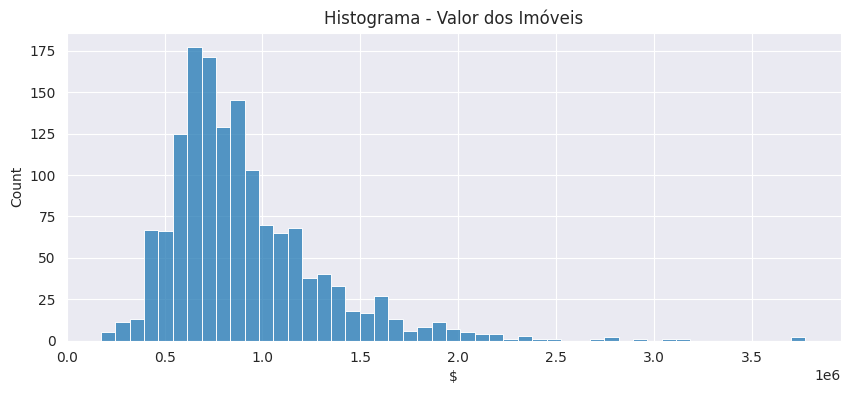

In [9]:
ax = sns.histplot(dados.valor)
ax.figure.set_size_inches(TAM_GRAFICO)
ax.set_title("Histograma - Valor dos Imóveis")
ax.set_xlabel("$")
plt.show()

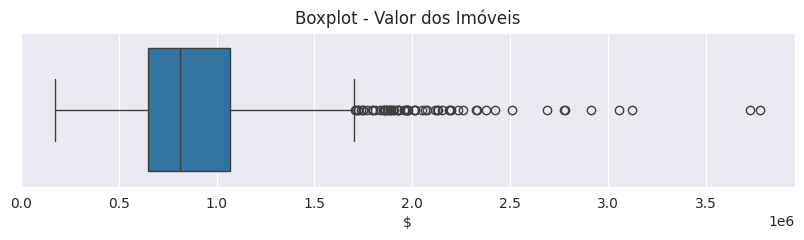

In [10]:
ax = sns.boxplot(x=dados.valor)
ax.figure.set_size_inches(10, 2)
ax.set_title("Boxplot - Valor dos Imóveis")
ax.set_xlabel("$")
plt.show()

* Os gráficos mostram que nossa variável dependente **valor** (y) é **assimétrica positiva** (muitos imóveis populares, poucos de alto padrão). Já era esperado, iremos tratar essa assimetria para usar em nosso modelo de previsão.

## 3.2. X: demais colunas

In [11]:
from ydata_profiling import ProfileReport

ProfileReport(dados, title="Infos das Casas")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:00<00:00, 66.04it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Principais observações:
*   As variáveis independentes (X) **"area_primeiro_andar"**, **"area_quintal"** e **"dist_metro"** são **assimétricas positivas**;
*   Algumas casas tem **area_quintal = 0**, ou seja, não possuem quintal;
*   Alta correlação da variável **"valor"** com **"area_primeiro_andar"** e **"area_quintal"**;
*   Correlação INVERSA de **"valor"** com **"dist_metro"**;
*   Alta correlação entre as variáveis **"area_primeiro_andar"** e **"area_quintal"**, pois a "area_primeiro_andar" inclui a "area_quintal". A prova disso é que não existe "area_quintal" maior ou igual a "area_primeiro_andar", segue abaixo:

In [12]:
(dados.area_quintal >= dados.area_primeiro_andar).sum()

np.int64(0)

## 3.3. Correlação entre as variáveis

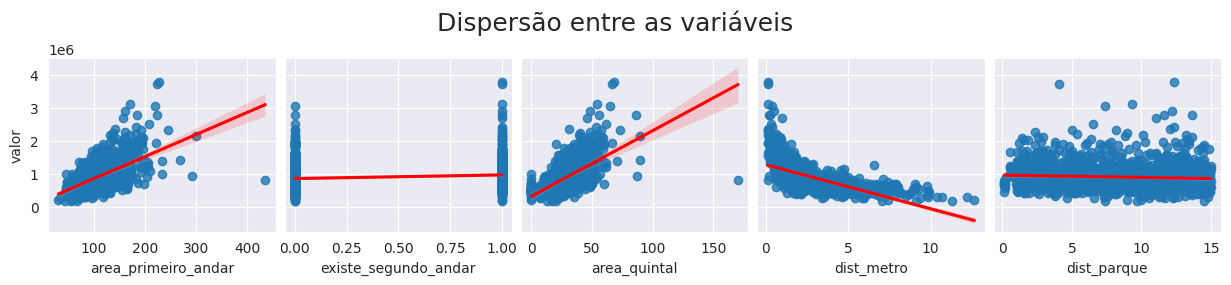

In [13]:
ax = sns.pairplot(dados, y_vars="valor", x_vars=dados.columns.drop("valor"), kind="reg", plot_kws={"line_kws": {"color": "red"}})
ax.figure.suptitle("Dispersão entre as variáveis", fontsize=TAM_TITLE, y=1.1)
plt.show()

Formatos não lineares (formatos de cone, etc) indicam assimetrias que precisam ser tratadas, como nas correlações de "valor" com "area_primeiro_andar", "area_quintal" e "dist_metro".
<br>Porém, esses gráficos já deixam claro que:
* A variável **"dist_metro"** impacta o **"valor"** de forma exponencial (os pontos em azul formam uma curva, não uma reta);
* A variável **"dist_parque"** se mostra NÃO relevante (os pontos se distribuem ao longo de todo o eixo X de forma indiferente). Confirmaremos isso mais abaixo.

### 3.3.1. Transformação com log

* Usaremos a função **log** para corrigir as variáveis assimétricas, deixando-as simétricas;
* Só temos que tomar cuidado com as variáveis que possuem valores 0 (zero) para não gerar erro na hora da transformação. Nelas usaremos a função **log1p**. Vejamos quais são:

In [14]:
dados.describe()

,valor,area_primeiro_andar,existe_segundo_andar,area_quintal,dist_metro,dist_parque
count,1.460000e+03,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,9.046060e+05,108.011548,0.432192,29.471432,2.774007,8.148135
std,3.972125e+05,35.915175,0.495550,12.227105,1.914356,4.202312
min,1.745000e+05,31.030000,0.000000,0.000000,0.103000,0.119000
25%,6.498750e+05,81.940000,0.000000,22.182500,1.419250,4.435500
50%,8.150000e+05,100.985000,0.000000,27.635000,2.263000,8.724500
75%,1.070000e+06,129.252500,1.000000,36.185000,3.886250,11.631250
max,3.775000e+06,435.900000,1.000000,170.290000,12.654000,14.998000


* Somente a variável **area_quintal** possui valores 0.

In [15]:
import numpy as np

dados_transformados = dados.copy()
dados_transformados.valor = np.log(dados.valor)
dados_transformados.area_primeiro_andar = np.log(dados.area_primeiro_andar)
dados_transformados.area_quintal = np.log1p(dados.area_quintal)
dados_transformados.dist_metro = np.log(dados.dist_metro)
dados_transformados

,valor,area_primeiro_andar,existe_segundo_andar,area_quintal,dist_metro,dist_parque
0,13.857132,4.376009,1,3.213260,0.494086,3.039
1,13.718449,4.764223,0,3.588230,0.430483,10.910
2,13.926605,4.448165,1,3.282414,0.242946,11.791
3,13.458836,4.491777,1,3.094219,0.201307,10.877
4,14.038654,4.666924,1,3.493777,-0.141564,11.247
...,...,...,...,...,...,...
1455,13.681979,4.483454,1,3.316365,1.093265,12.175
1456,13.864301,5.260564,0,3.783735,0.839410,2.608
1457,14.102567,4.703838,1,3.499835,0.225541,13.424
1458,13.473900,4.606669,0,3.435277,1.505632,1.087


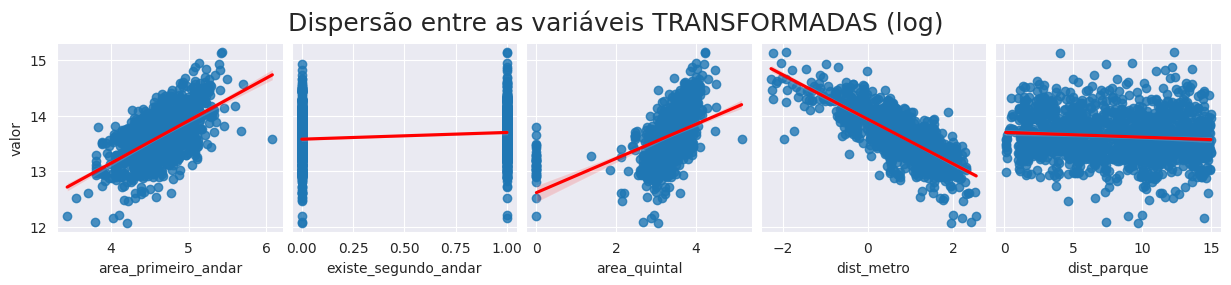

In [16]:
ax = sns.pairplot(dados_transformados, y_vars="valor", x_vars=dados.columns.drop("valor"), kind="reg", plot_kws={"line_kws": {"color": "red"}})
ax.figure.suptitle("Dispersão entre as variáveis TRANSFORMADAS (log)", fontsize=TAM_TITLE, y=1.1)
plt.show()

Houve uma melhora nas assimetrias.

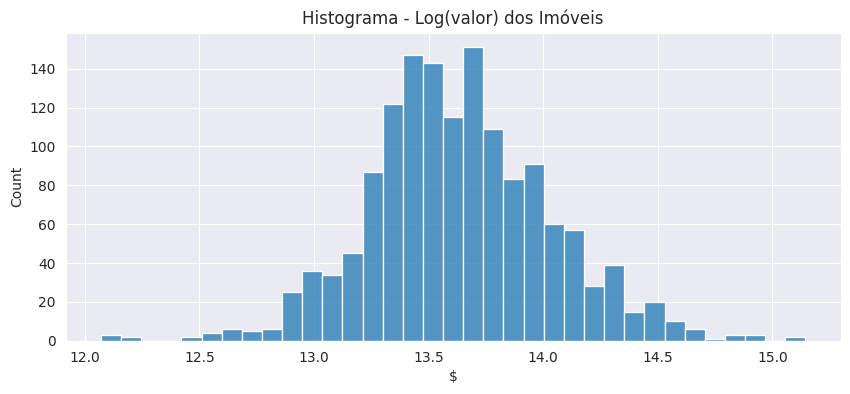

In [17]:
ax = sns.histplot(dados_transformados.valor)
ax.figure.set_size_inches(TAM_GRAFICO)
ax.set_title("Histograma - Log(valor) dos Imóveis")
ax.set_xlabel("$")
plt.show()

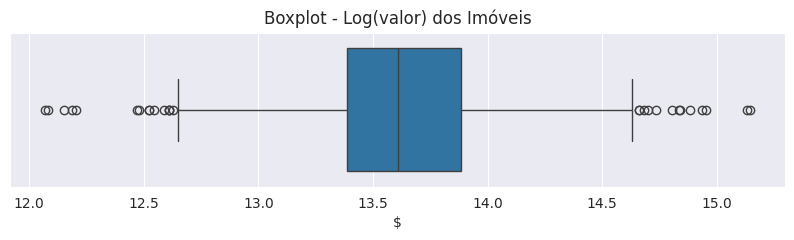

In [18]:
ax = sns.boxplot(x=dados_transformados.valor)
ax.figure.set_size_inches(10, 2)
ax.set_title("Boxplot - Log(valor) dos Imóveis")
ax.set_xlabel("$")
plt.show()

Houve uma melhora na assimetria da variável **"valor"**.

# 4. Estatísticas descritivas

In [19]:
import statsmodels.api as sm

X = dados_transformados.drop(columns="valor")
X_com_constante = sm.add_constant(X)
y = dados_transformados.valor

modelo_statsmodels = sm.OLS(y, X_com_constante, hasconst=True).fit()
print(modelo_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:                  valor   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     888.1
Date:                Thu, 05 Feb 2026   Prob (F-statistic):               0.00
Time:                        20:15:52   Log-Likelihood:                 290.39
No. Observations:                1460   AIC:                            -568.8
Df Residuals:                    1454   BIC:                            -537.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.1917 

**"dist_parque"** tem **p-valor > 0,05**. Não há provas suficientes para rejeitar a hipótese nula, ou seja, essa variável é **estatisticamente insignificante** (ao nível de confiança de 95%), não impactando em nada o valor do imóvel (como já vimos nos gráficos acima). Sendo assim, **NÃO A USAREMOS** no nosso modelo.

In [26]:
X = X.drop(columns="dist_parque")

# 5. Modelo: Regressão Linear

## 5.1. Treino e teste

In [27]:
from sklearn.model_selection import train_test_split
SEED = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

Variáveis com **escalas muito diferentes** devem ser padronizadas para uma melhor eficiência de certos modelos de machine learning, como os de regressão e os baseados em distância (KNN, etc).

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform="pandas")
colunas_padronizar = "area_primeiro_andar existe_segundo_andar area_quintal dist_metro".split()
X_train_padronizado = scaler.fit_transform(X_train[colunas_padronizar])

X_test_padronizado = scaler.transform(X_test[colunas_padronizar])

## 5.2. Treinamento

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

modelo = LinearRegression()
modelo.fit(X_train_padronizado, y_train)

LinearRegression()

## 5.3. R² Score
Medida que explica o quão bem o  modelo de regressão se ajusta aos dados observados. Quanto mais próximo de 1, melhor:

In [49]:
y_pred_train = modelo.predict(X_train_padronizado)
print(f"R² treino: {r2_score(y_train, y_pred_train)}")

R² treino: 0.7634848154942713


In [50]:
y_pred = modelo.predict(X_test_padronizado)
print(f"R² TESTE: {r2_score(y_test, y_pred)}")

R² TESTE: 0.709326452715429


### 5.3.1. Validação cruzada
Necessária para uma resposta mais robusta e não enviesada por sorte/azar de uma única separação de treino/teste:

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(StandardScaler(), LinearRegression())
scores = cross_val_score(pipeline, X, y, scoring="r2")
print(f"R² validação cruzada (5-fold): {scores.mean()}")

R² validação cruzada (5-fold): 0.7498619612997308


### 5.3.2. Baseline DummyRegressor

Modelo bem simples para compararmos se nosso modelo está se saindo realmente melhor que ele:

In [33]:
from sklearn.dummy import DummyRegressor

pipeline_dummy = make_pipeline(StandardScaler(), DummyRegressor())
scores_dummy = cross_val_score(pipeline_dummy, X, y, scoring="r2")
print(f"R² DUMMY: {scores_dummy.mean()}")

R² DUMMY: -0.003468324498284092


Nosso modelo está se saindo bem melhor que isso!

Além da métrica R², veremos se os erros do nosso modelo estão dentro dos conformes:

## 5.4. Gráficos dos resíduos

### 5.4.1. Dispersão das previsões

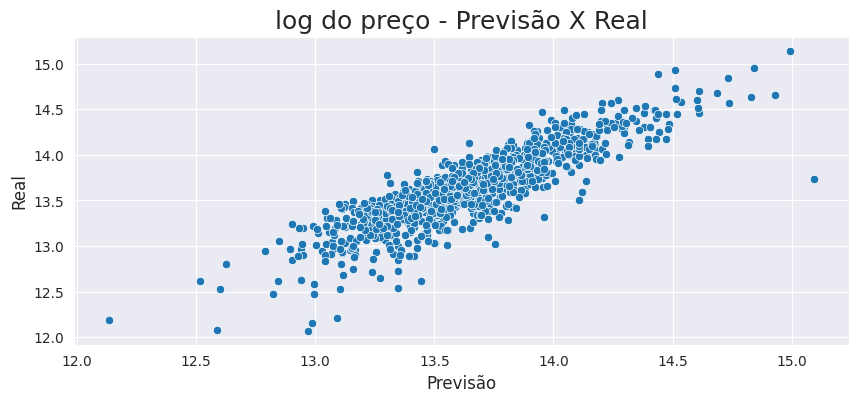

In [34]:
ax = sns.scatterplot(x=y_pred_train, y=y_train)
ax.figure.set_size_inches(TAM_GRAFICO)
ax.set_title("log do preço - Previsão X Real", fontsize=TAM_TITLE)
ax.set_xlabel("Previsão", fontsize=TAM_LABEL)
ax.set_ylabel("Real", fontsize=TAM_LABEL)
plt.show()

Predominância de uma linha reta (OK).

### 5.4.2. Frequência dos resíduos

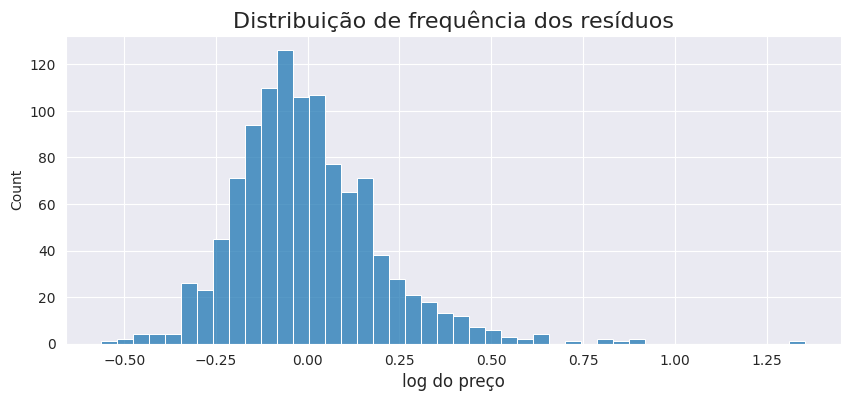

In [36]:
residuos = y_pred_train - y_train
ax = sns.histplot(residuos)
ax.figure.set_size_inches(TAM_GRAFICO)
ax.set_title("Distribuição de frequência dos resíduos", fontsize=16)
ax.set_xlabel("log do preço", fontsize=TAM_LABEL)
plt.show()

A distribuição é normal, com os resíduos centralizados ao redor do valor zero (OK).

### 5.4.3. Homocedasticidade do modelo

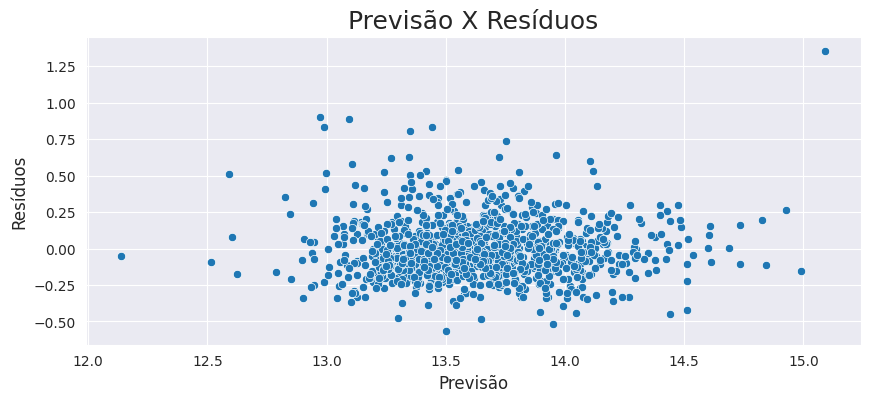

In [37]:
ax = sns.scatterplot(x=y_pred_train, y=residuos)
ax.figure.set_size_inches(TAM_GRAFICO)
ax.set_title("Previsão X Resíduos", fontsize=TAM_TITLE)
ax.set_xlabel("Previsão", fontsize=TAM_LABEL)
ax.set_ylabel("Resíduos", fontsize=TAM_LABEL)
plt.show()

Distribuição relativamente constante ao longo do eixo horizontal (OK).

# 6. Salvando modelo

Junto com o StandardScaler, pois os 2 serão necessários para futuras previsões:

In [52]:
import pickle

modelo_e_scaler = (modelo, scaler)
arquivo = open("modelo_e_scaler_precifica_casas", "wb")
pickle.dump(modelo_e_scaler, arquivo)
arquivo.close()

## 6.1. Carregando modelo e fazendo novas previsões

In [53]:
arquivo = open("modelo_e_scaler_precifica_casas", "rb")
modelo, scaler = pickle.load(arquivo)
arquivo.close()

In [40]:
# EXEMPLO IMÓVEL X
area_primeiro_andar = 79.52
existe_segundo_andar = 1
area_quintal = 23.86
dist_metro = 1.639
dist_parque = 3.039 # Não usaremos

In [88]:
def previsao(dados):
    dados_transformados = pd.DataFrame({
        "area_primeiro_andar": np.log(dados.area_primeiro_andar),
        "existe_segundo_andar": dados.existe_segundo_andar,
        "area_quintal": np.log1p(dados.area_quintal),
        "dist_metro": np.log(dados.dist_metro)
    })
    dados_padronizados = scaler.transform(dados_transformados)

    previsao = modelo.predict(dados_padronizados)
    resultado = np.exp(previsao)
    return resultado

In [118]:
novos_dados = pd.DataFrame({
    "area_primeiro_andar": [area_primeiro_andar],
    "existe_segundo_andar": [existe_segundo_andar],
    "area_quintal": [area_quintal],
    "dist_metro": [dist_metro]
})
prev = previsao(novos_dados)
print(f"Preço previsto: ${prev[0]:,.2f}")

Preço previsto: $869,214.43
